## Accessing TerraClimate data with the Planetary Computer STAC API

[TerraClimate](http://www.climatologylab.org/terraclimate.html) is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

This example will show you how temperature has increased over the past 60 years across the globe.

### Environment setup

In [1]:
import warnings
import os
warnings.filterwarnings("ignore", "invalid value", RuntimeWarning)

### Data access

https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate is a STAC Collection with links to all the metadata about this dataset. We'll load it with [PySTAC](https://pystac.readthedocs.io/en/latest/).

In [2]:
import pystac

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
collection

<Collection id=terraclimate>

The collection contains assets, which are links to the root of a Zarr store, which can be opened with xarray.

In [12]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://cpdataeuwest.blob.core.windows.net/cpdata/raw/terraclimate/4000m/raster.zarr>

In [13]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We'll process the data in parallel using [Dask](https://dask.org).

In [16]:
pwd()

'/home/jovyan/PlanetaryComputerExamples/datasets/terraclimate'

In [14]:
# from dask_gateway import GatewayCluster
%run helper.ipynb
setup_dask_cluster()

NameError: name 'setup_dask_cluster' is not defined

### Subset based on lat long of interest

In [ ]:
# lon_point_list = [-85.9, -82, -82, -85.9]
# lat_point_list = [11.3, 11.3, 8, 8]

# ds.isel(lat=slice(-86, -82), lon=slice(8, 11.3))

cr=ds.sel(lat=slice(11.3, 8), lon=slice(-85.9,-82))

In [ ]:
# cr['tmax']
type(cr)

In [ ]:
sum(cr.tmax.isnull())

The link printed out above can be opened in a new tab or the [Dask labextension](https://github.com/dask/dask-labextension). See [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask, and how to access the Dashboard.

### Analyze and plot global temperature

We can quickly plot a map of one of the variables. In this case, we are downsampling (coarsening) the dataset for easier plotting.

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

average_max_temp = cr.isel(time=-1)["tmax"].load()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

average_max_temp.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

In [ ]:
type(cr)

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.load()` to execute the command instead of specifying it lazily.  Note that there are some data quality issues before 1965 so we'll start our analysis there.

In [ ]:
temperature = (
    cr["tmax"].sel(time=slice("2011", None)).mean(dim=["lat", "lon"]).persist()
)

In [ ]:
temperature.plot(figsize=(12, 6));

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

In [ ]:
temperature.groupby("time.year").mean().plot(figsize=(12, 6));

Now the increase in temperature is obvious, even when averaged across the entire domain.

### High res filteration 

In [ ]:
import geopandas
import cartopy

countries = geopandas.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)

In [ ]:
cr_polygon=countries[countries['ISO_A2']=='CR']

In [ ]:
cr_polygon['geometry'] = cr_polygon['geometry'].set_crs("EPSG:4326")

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import shapely as sh


lon_point_list = [-85.9, -82, -82, -85.9]
lat_point_list = [11.3, 11.3, 8, 8]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = 'epsg:4326'
bounding_box = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

In [ ]:
# cr_core = gpd.overlay(cr_polygon, bounding_box, how='intersection')
cr_core=cr_polygon.copy()
cr_core.plot()

In [ ]:
type(cr_core), cr_core.head()

In [ ]:
cr

In [ ]:
cr['pdsi']

In [ ]:
# Converting xarray dataframe (points) to geopandas dataframe
# def 
param=['tmax','pdsi']
xarr_df=cr

xarr = xarr_df[param]
df = xarr.to_dask_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df[param], geometry=gpd.points_from_xy(df.lon,df.lat))

In [ ]:
len(xarr_df)

In [ ]:
xarr_df['pdsi']

In [ ]:
df.head()

In [76]:
gdf.head()

,tmax,tmin,geometry
0,31.800003,20.400002,POINT (-85.89583 11.27083)
1,31.500000,20.099998,POINT (-85.85417 11.27083)
2,31.200005,19.900002,POINT (-85.81250 11.27083)
3,31.200005,19.900002,POINT (-85.77083 11.27083)
4,31.800003,20.500000,POINT (-85.72917 11.27083)


In [80]:
len(df), len(gdf)

(5524944, 5524944)

In [81]:
df.isna().sum()

time          0
lat           0
lon           0
tmax    2857704
tmin    2857704
dtype: int64

<AxesSubplot:>

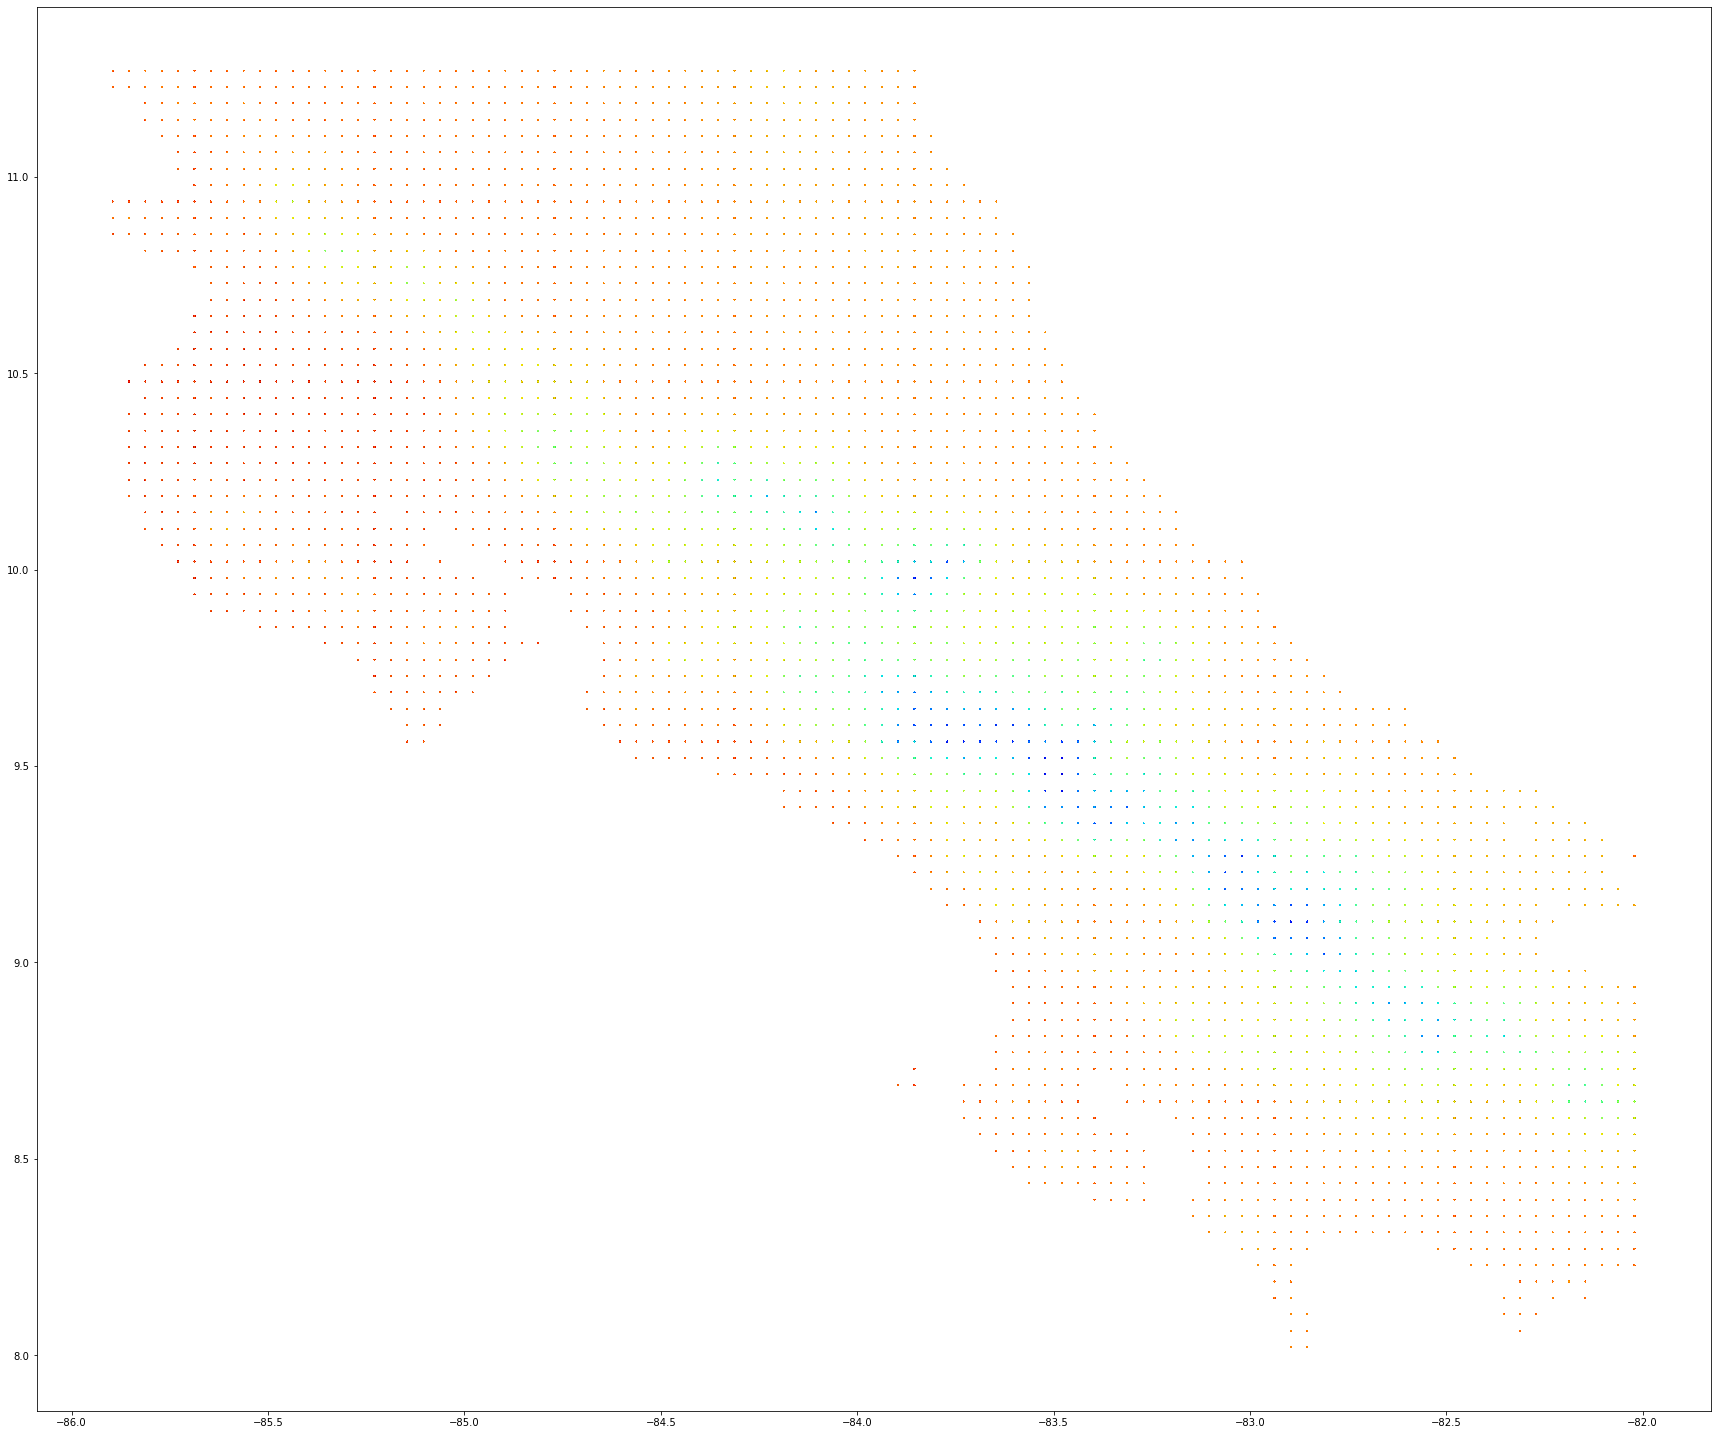

In [82]:
gdf.plot(markersize=0.01, figsize=(30,30), column='tmax', cmap='jet')

In [51]:
xarr_df['tmax'].isna()

AttributeError: 'DataArray' object has no attribute 'isna'

In [27]:
os.listdir()

['my_rasterized_column.tif',
 'terraclimate-example.ipynb',
 '.ipynb_checkpoints']

In [30]:
os.listdir('/home/jovyan/final-project-team-ando-shravan-final_proj/scripts/')

['gbif-exploration-SU.ipynb',
 '.ipynb_checkpoints',
 'helper.ipynb',
 'gbif-example-Copy1.ipynb',
 'gbif-helper.ipynb',
 'cr_species_gpd_clean.shp']

In [31]:
os.chdir('/home/jovyan/final-project-team-ando-shravan-final_proj/scripts/')

In [34]:
#setting crs
gdf.set_crs(epsg=4326, inplace=True)

,tmax,geometry
0,31.800003,POINT (-85.89583 11.27083)
1,31.500000,POINT (-85.85417 11.27083)
2,31.200005,POINT (-85.81250 11.27083)
3,31.200005,POINT (-85.77083 11.27083)
4,31.800003,POINT (-85.72917 11.27083)
...,...,...
5524939,NaN,POINT (-82.18750 8.02083)
5524940,NaN,POINT (-82.14583 8.02083)
5524941,NaN,POINT (-82.10417 8.02083)
5524942,NaN,POINT (-82.06250 8.02083)


In [36]:
gdf.isna().sum(), len(gdf)

(tmax        2857704
 geometry          0
 dtype: int64,
 5524944)

In [ ]:
gdf.crs

In [ ]:
cr_core.crs

In [ ]:
gdf_sample=gdf.iloc[0:100000]
len(gdf_sample)

In [ ]:
1.7*len(gdf)/100000

In [ ]:
%%time
cr_core_temp = gpd.overlay(gdf, cr_core, how='intersection')
cr_core_temp

In [ ]:
len(cr_core_temp)
1,808,664

In [ ]:
%%time
cr_core_temp_sample=cr_core_temp.iloc[0:100000]
cr_core_temp_sample.plot()

In [ ]:
cr_core_temp_sample

In [ ]:
cr_core_temp_sample.info()

In [ ]:
from geocube.api.core import make_geocube

out_grid= make_geocube(vector_data=cr_core_temp_sample, resolution=(-0.05, 0.05), fill=-999) #for most crs negative comes first in resolution

In [ ]:
out_grid_tmax=out_grid.copy()
out_grid_tmax=0
for i in range(len(out_grid['x'])):
    for j in range(len(out_grid['y'])):
        # temp=out_grid_tmax.sel(lat=slice(11.3, 8), lon=slice(-85.9,-82))
        print(lat=out_grid['x'][i])
        
        

In [ ]:
out_grid['tmax']=0

In [ ]:
out_grid

In [ ]:
cr_core_temp_sample.plot(column='tmax', legend=True)

In [ ]:
import os
os.listdir('/home/jovyan/final-project-team-ando-shravan-final_proj/scripts/')
# gbif-helper.ipynb

In [ ]:
os.chdir('/home/jovyan/final-project-team-ando-shravan-final_proj/scripts/')

In [ ]:
%run gbif-helper.ipynb